# Setup

In [5]:
# # Setup
# !pip install --quiet --upgrade pip

# # Install the dependencies.
# !pip install --quiet -r requirements_tf.txt
# !pip install wandb -q
# !pip install opencv-python -q

ERROR: To modify pip, please run the following command:
C:\Users\tskor\Documents\GitHub\inovation_project\.ml-venv\Scripts\python.exe -m pip install --quiet --upgrade pip
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
geemap 0.34.5 requires earthengine-api>=1.0.0, but you have earthengine-api 0.1.395 which is incompatible.
geemap 0.34.5 requires folium>=0.17.0, but you have folium 0.16.0 which is incompatible.
pylint 3.3.0 requires dill>=0.3.6; python_version >= "3.11", but you have dill 0.3.1.1 which is incompatible.
pylint 3.3.0 requires dill>=0.3.7; python_version >= "3.12", but you have dill 0.3.1.1 which is incompatible.


In [ ]:
# Restart the runtime by ending the process
exit()

In [1]:
import os
import matplotlib.pyplot as plt


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages, 1 = INFO, 2 = WARNING, 3 = ERROR
import numpy as np
import pandas as pd
import tensorflow as tf
from google.cloud import storage
import google.auth
from importlib import reload
from serving.constants import  BUCKET, IMG_SOURCE_PREFIX, HIST_DEST_PREFIX, HIST_BINS_LIST, SCALE, CROP, MONTHS, IMAGE_BATCH, NUM_BINS, MAP_NAN, NORMALIZE, LABELS_PATH, HEADER_PATH, SELECTED_BANDS
from serving.common import list_blobs_with_prefix
from serving.hist_training import (get_labels,
                                   #LstmModel,
                                   #TimeDependentDenseLstmModel,
                                   pen_low_lenient_high_loss,
                                   pen_low_loss,
                                   load_dataset_from_gcp,
                                   save_dataset_to_gcp,
                                   create_hist_dataset,
                                   train_wandb,
                                   train_model_data,
                                   plot_training_progress)
from serving.data import check_blob_prefix_exists, batch_check_blobs, get_varied_labels, check_blob_exists
import logging
import io
import itertools
import time

from keras.layers import LSTM, Dense, Dropout, Input, Normalization
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import wandb
# from google.cloud import secretmanager

tf.config.run_functions_eagerly(True)

# Models

In [227]:
# Models
import keras
from keras.layers import LSTM, Dense, Dropout, Input, TimeDistributed, BatchNormalization, GRU. Add
from tensorflow.keras.regularizers import l2
from serving.data import get_labels
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
import randomname
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
import tempfile
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
from tensorflow.keras.constraints import MaxNorm, MinMaxNorm, NonNeg

class GradientDebugCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.batch_gradients = []

    def on_batch_begin(self, batch, logs=None):
        self.batch_gradients = []

    def on_batch_end(self, batch, logs=None):
        if batch % 100 == 0:  # Monitor every 10 batches
            # Get a batch of data
            for x_batch, y_batch in train_dataset.take(1):
                with tf.GradientTape() as tape:
                    # Forward pass
                    y_pred = self.model(x_batch, training=True)
                    # Compute loss
                    loss = self.model.compute_loss(y_batch, y_pred)

                # Get gradients
                gradients = tape.gradient(loss, self.model.trainable_variables)
                # grad_norms = [tf.norm(g).numpy() if g is not None else 0 for g in gradients]
                for i, (var, grad) in enumerate(zip(self.model.trainable_variables, gradients)):
                    if grad is not None:
                        print(f"\nLayer: {var.name}")
                        print(f"Parameter shape: {var.shape}")
                        print(f"Gradient norm: {tf.norm(grad).numpy()}")
                        print(f"Is trainable: {var.trainable}")

                # print(f"\nBatch {batch}")
                # print("Loss:", loss.numpy())
                # print("Gradient norms:", grad_norms)
                # print("Predictions:", y_pred.numpy()[:5])
                # print("Targets:", y_batch.numpy()[:5])


# Define the LSTM model
class LstmModel(keras.Model):
    def __init__(
        self,
        input_shape,
        lstm_layers=3,
        no_units=3,
        output_units=1,
        dropout_rate=0.2,
        val_size=10,
        kernel_initializer=tf.keras.initializers.RandomNormal()
    ):
        super(LstmModel, self).__init__()
        self.lstm_layers = lstm_layers
        self.no_units = no_units
        self.output_units = output_units
        self.dropout_rate = dropout_rate
        self.val_size = val_size

        self.input_layer = Input(shape=input_shape)
        self.batch_norm = BatchNormalization()
        
        # Define LSTM and Dense layers
        self.lstm_layers_list = []
        for i in range(lstm_layers):
            self.lstm_layers_list.append(
                LSTM(
                    units=no_units,
                    return_sequences=(i < lstm_layers - 1),
                    kernel_initializer='glorot_uniform',
                    recurrent_initializer='orthogonal',
                    activation='tanh'
                )
            )
            
            if i < lstm_layers - 1:
                self.lstm_layers_list.append(Dropout(rate=dropout_rate))
        
        self.dense = Dense(
            units=output_units,
            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
            bias_initializer=tf.keras.initializers.Constant(100.0)
        )
        
        self.job_name = randomname.get_name(adj=('emotions',), noun=('food'))
    
    def get_config(self):
        return {
           "lstm_layers": self.lstm_layers,
           "no_units": self.no_units,
           "val_size": self.val_size,
           "ouput_units": self.output_units,
           "dropout_rate": self.dropout_rate,
           "kernel_initializer": self.kernel_initializer
        }
    
    @classmethod
    def from_config(cls, config):
        # Convert the serialized initializer back to a TF initializer
        config['kernel_initializer'] = tf.keras.initializers.deserialize(
            config['kernel_initializer']
        )
        return cls(**config)
    
    @tf.function
    def call(self, inputs, training=False):
        # LSTM layers

        x = inputs
        #x = self.batch_norm(x, training=training)

        for lstm_layer in self.lstm_layers_list:
            x = lstm_layer(x)

        outputs = self.dense(x)

        return outputs

    def summary(self):
        super(LstmModel, self).summary()

    def compile(
        self, optimizer="adam", loss="mse", metrics=["mae"], learning_rate=0.001, **kwargs
    ):
        self.learning_rate = learning_rate

        # Dictionary to map optimizer names to their classes
        optimizers = {"adam": Adam, "nadam": Nadam, "rms": RMSprop}

        # Get the optimizer class from the dictionary
        optimizer_class = optimizers.get(optimizer.lower(), Adam)

        # Instantiate the optimizer with the specified learning rate
        optimizer_instance = optimizer_class(learning_rate=learning_rate, clipnorm=1.0)

        # Compile the model with the chosen optimizer, loss, and metrics
        tf.config.run_functions_eagerly(True)
        
        if loss != "mse" and "mse" not in metrics:
            metrics.append("mse")
        
        super(LstmModel, self).compile(
            optimizer=optimizer_instance, loss=loss, metrics=metrics, **kwargs
        )
        
    

    def fit(self, dataset, epochs=10):

        # Shuffle and batch the dataset
        # dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)

        # Split the dataset
        val_size = self.val_size
        val_dataset = dataset.take(val_size)
        train_dataset = dataset.skip(val_size)

        # Setup tensorboard
        model_name = f"{NUM_BINS}_buckets_{len(HIST_BINS_LIST)}" + '-' + self.job_name + '-' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        log_dir = "gs://vgnn/tensorboard-artifacts/logs/fit/" + model_name
        if not os.path.exists(os.path.dirname(log_dir)):
            os.makedirs(os.path.dirname(log_dir))
            
        
        # Early stopping callback
        early_stopping = EarlyStopping(
            monitor="val_loss", patience=15, restore_best_weights=True
        )

        
        # Train the model
        history = super(LstmModel, self).fit(
            train_dataset,
            epochs=epochs,
            # batch_size=batch_size,
            validation_data=val_dataset,
            callbacks=[early_stopping, GradientDebugCallback(), WandbMetricsLogger()]
        )
        
        responses_train = np.concatenate(
            [response.numpy() for _, response in train_dataset], axis=0
        )
        mean_response_train = np.mean(responses_train)

        responses_val = np.concatenate(
            [response.numpy() for _, response in val_dataset], axis=0
            )        

        if val_size == 0:
            self.naive_loss = np.nan
        else:
            self.naive_loss = pen_low_lenient_high_loss(responses_val, mean_response_train)        
        
        # Plot training progress
        plot_training_progress(history, self.naive_loss)

        # Evaluate the model
        loss = self.evaluate(val_dataset)

        self.save(f'gs://vgnn/models/{model_name}.h5')

        return history


class TimeDependentDenseLstmModel(keras.Model):
    def __init__(
        self,
        input_shape,
        lstm_layers=3,
        no_units=3,
        dense_layers_per_step=3,
        output_units=1,
        dropout_rate=0.2,
        val_size=10,
        kernel_initializer=tf.keras.initializers.RandomNormal()
    ):
        super(TimeDependentDenseLstmModel, self).__init__()
        self.lstm_layers = lstm_layers
        self.no_units = no_units
        self.output_units = output_units
        self.dropout_rate = dropout_rate
        self.val_size = val_size

        self.input_layer = Input(shape=input_shape)

        self.lstm_layers = lstm_layers
        self.dense_layers_per_step = dense_layers_per_step
        self.no_units = no_units
        self.val_size = val_size
        self.dropout_rate = dropout_rate
        self.kernel_initializer = kernel_initializer    

        self.model_name = randomname.get_name(adj=('emotions',), noun=('food')) + '-' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")   
        self.input_norm = BatchNormalization()
        
        # Define LSTM and Dense layers
        self.lstm_layers_list = []
        self.lstm_norm_layers = []  

        for i in range(lstm_layers):
            self.lstm_layers_list.append(
                LSTM(
                    units=no_units,
                    return_sequences=(i < lstm_layers - 1),
                    kernel_initializer='glorot_uniform',
                    recurrent_initializer='Orthogonal',
                    activation='sigmoid',
                    kernel_regularizer=l2(0.01),
                    recurrent_regularizer=l2(0.01),
                    dropout=0.1,
                    recurrent_dropout=0.1,
                    stateful=False,
                    unroll=True,
                    bias_constraint=MaxNorm(max_value=1.0)                                   
                )
            )

            self.lstm_norm_layers.append(
                BatchNormalization()
            )            
            
            if i < lstm_layers - 1:
                self.lstm_layers_list.append(Dropout(rate=dropout_rate))
        
        self.dense = Dense(
            units=output_units,
            kernel_initializer=tf.keras.initializers.RandomNormal(),
            # use_bias=False
        )

        self.global_skip = Dense(units=input_shape[-1],
                                 activation="relu",
                                 kernel_initializer=tf.keras.initializers.RandomNormal()
                                 )
        self.global_skip_norm = BatchNormalization()                                 
        
        # Dense layer to process each time step using TimeDistributed
        self.time_distributed_dense = []
        # Create the dense layers that will be applied to each time step
        units = input_shape[-1] 
        for _ in range(dense_layers_per_step):
            self.time_distributed_dense.append(
                TimeDistributed(Dense(units=units, 
                                      activation="relu",
                                      kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
                                      bias_initializer='ones',
                                      bias_regularizer=l2(0.1) ))
            )
            # units //= 2  # Halve units for each subsequent dense layer

    def get_config(self):
        return {
           "lstm_layers": self.lstm_layers,
           "no_units": self.no_units,
           "val_size": self.val_size,
           "ouput_units": self.output_units,
           "dropout_rate": self.dropout_rate,
           "kernel_initializer": self.kernel_initializer,
           'dense_layers_per_step': self.dense_layers_per_step
        }        
    
        
    @classmethod
    def from_config(cls, config):
        # Convert the serialized initializer back to a TF initializer
        config['kernel_initializer'] = tf.keras.initializers.deserialize(
            config['kernel_initializer']
        )
        return cls(**config)

    @tf.function
    def call(self, inputs, training=False):
        # Process each time step with a corresponding dense layer
        residual = inputs
        # x = inputs
        x = self.input_norm(inputs, training=training)
        for dense_layer in self.time_distributed_dense:
            x = dense_layer(x)
        
        # Feed into LSTM layers
        for lstm_layer, norm_layer in zip(self.lstm_layers_list, self.lstm_norm_layers):
            if isinstance(lstm_layer, LSTM):
                x = lstm_layer(x)
                x = norm_layer(x, training=training)
            else:  # Dropout layer
                x = lstm_layer(x)

        # Intermediate dense layer
        x = self.global_skip(x)
        x = self.global_skip_norm(x, training=training)
        
        # Add residual connection (mean pooling over time steps since LSTM reduced time dimension)
        residual = tf.reduce_mean(residual, axis=1)  # Average over time steps
        x = Add()([x, residual])

        outputs = self.dense(x)  # Final dense layer for output
        return outputs


    def summary(self):
        super(TimeDependentDenseLstmModel, self).summary()

    def compile(
        self, optimizer="adam", loss="mse", metrics=["mae"], learning_rate=0.001, **kwargs
    ):
        self.learning_rate = learning_rate

        # Dictionary to map optimizer names to their classes
        optimizers = {"adam": Adam, "nadam": Nadam, "rms": RMSprop}

        # Get the optimizer class from the dictionary
        optimizer_class = optimizers.get(optimizer.lower(), Adam)

        # Instantiate the optimizer with the specified learning rate
        optimizer_instance = optimizer_class(learning_rate=learning_rate,
                                            clipnorm=1.0,
                                            # clipvalue=0.5,
                                            # global_clipnorm=1.0
                                            )

        # Compile the model with the chosen optimizer, loss, and metrics
        tf.config.run_functions_eagerly(True)
        
        if loss != "mse" and "mse" not in metrics:
            metrics.append("mse")
        
        super(TimeDependentDenseLstmModel, self).compile(
            optimizer=optimizer_instance, loss=loss, metrics=metrics, **kwargs
        )

    def fit(self, dataset, epochs=10, local=False):

        # Shuffle and batch the dataset
        # dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)

        # Split the dataset
        val_size = self.val_size
        val_dataset = dataset.take(val_size)
        train_dataset = dataset.skip(val_size)

        # Early stopping callback
        early_stopping = EarlyStopping(
            monitor="val_loss", patience=15, restore_best_weights=True
        )

        # Train the model
        history = super(TimeDependentDenseLstmModel, self).fit(
            train_dataset,
            epochs=epochs,
            # batch_size=batch_size,
            validation_data=val_dataset,
            callbacks=[early_stopping, GradientDebugCallback(), WandbMetricsLogger()]
        )
        
        responses_train = np.concatenate(
            [response.numpy() for _, response in train_dataset], axis=0
        )
        mean_response_train = np.mean(responses_train)

        responses_val = np.concatenate(
            [response.numpy() for _, response in val_dataset], axis=0
            )        

        if val_size == 0:
            self.naive_loss = np.nan
        else:
            self.naive_loss = pen_low_lenient_high_loss(responses_val, mean_response_train)        
        
        # Plot training progress
        plot_training_progress(history, self.naive_loss)

        # Evaluate the model
        loss = self.evaluate(val_dataset)

        if local:
            self.save(f'{self.model_name}.keras')
        else:
            self.save(f'gs://vgnn/models/{self.model_name}.keras')

        return history

SyntaxError: invalid syntax (3412101086.py, line 3)

### Data prep

In [25]:
# SETUP

# Create the Secret Manager client
# client = secretmanager.SecretManagerServiceClient()

# Define the secret name and version
secret_name = "projects/1038596154733/secrets/wandb/versions/1"

# Access the secret
# response = client.access_secret_version(name=secret_name)
# secret_value = response.payload.data.decode('UTF-8')

#####
CREATE_DATASET = False
#####

start_time = time.perf_counter()
credentials, _ = google.auth.default()
bucket_name = BUCKET
directory_prefix = IMG_SOURCE_PREFIX
output_prefix = HIST_DEST_PREFIX
labels_data = "labels_combined.npy"
labels_header = "labels_header.npy"
months = MONTHS
map_nan = MAP_NAN
normalize = NORMALIZE
num_bins = NUM_BINS
client = storage.Client()
bucket = client.get_bucket(bucket_name)


batch_size = 10
img_range =  {"count_start":0,
              "no_records":10,
             "ascending": False}

In [4]:
# map_nan = True
# num_buckets_list = [60]
# num_bands_list = [9]
# CREATE_DATASET = False

# for num_bins, num_bands in zip(num_buckets_list, num_bands_list):
#     directory = f"dataset/nan_map_{map_nan}/norm_{normalize}/{num_bins}_buckets_{num_bands}_bands/{SCALE}"
#     print(f"directory: {directory}")
#     file_name =  "dataset.tfrecords" # "hist_dataset_medium" # 


#     if CREATE_DATASET:
#         # Generate all prefixes
#         start_time = time.perf_counter()

#         labels_df = get_varied_labels(**img_range)
#         labels = list(zip(labels_df["county_name"],
#                           labels_df["county_ansi"],
#                      labels_df["state_ansi"],
#                      labels_df["year"]))


#         prefixes_hist = [f'histograms/nan_map_{map_nan}/norm_{normalize}/{num_bins}_buckets_{num_bands}_bands/{SCALE}/{county.capitalize()}_{fips}/{year}' 
#                     for county,_, fips, year in labels
#                         for month in months]

#         # Batch check all prefixes
#         results_hist = batch_check_blobs(bucket_name, prefixes_hist)

#         # Generate get_input_img_params based on results
#         get_input_img_params = [(county.capitalize(), fips, year)
#                     for county, county_fips, fips, year in labels
#                     if results_hist[f'histograms/nan_map_{map_nan}/norm_{normalize}/{num_bins}_buckets_{num_bands}_bands/{SCALE}/{county.capitalize()}_{fips}/{year}']
#         ]

#         print(f"Number of items to process: {len(get_input_img_params)}")

#         end_time_dataset_info = time.perf_counter()
#         print(f"Collecting dataset information: {end_time_dataset_info-start_time}")

#         dataset, dataset_shape, hist_npy, labels_npy = create_hist_dataset(get_input_img_params, "labels_combined.npy", "labels_header.npy", num_bins=num_bins, num_bands=num_bands)
#         end_time_dataset = time.perf_counter()

#         print(f"Building dataset: {(end_time_dataset - end_time_dataset_info)/60:.02} minutes")

#         # Save dataset
#         save_dataset_to_gcp(hist_npy, labels_npy, directory=directory)
#         print("Dataset created")
#         print(directory,file_name,sep="/")
#         CREATE_DATASET = False
#     else:

#         dataset, dataset_shape = load_dataset_from_gcp(directory=directory)
#         print("Dataset loaded")

#     input_shape = dataset_shape[1:]

directory: dataset/nan_map_True/norm_True/60_buckets_9_bands/60
Dataset loaded


In [238]:
dataset_path = r"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline\test_data\dataset_nan_map_True_norm_True_60_buckets_12_bands_60_dataset.npy"
labels_path = r"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline\test_data\dataset_nan_map_True_norm_True_60_buckets_12_bands_60_labels.npy"

np_dataset = np.load(dataset_path, allow_pickle=True)
zero_mask = np_dataset==0
np_dataset[~zero_mask] = np.log(np_dataset[~zero_mask])

np_labels =  np.load(labels_path, allow_pickle=True)

# Create TensorFlow tensors
histogram_tensor = tf.convert_to_tensor(np_dataset, dtype=tf.float32)
label_tensor = tf.convert_to_tensor(np_labels, dtype=tf.float32)

# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((histogram_tensor, label_tensor))  

dataset_shape = np_dataset.shape
input_shape = dataset_shape[1:]

print(f"Dataset shape: {dataset_shape}")
print(f"Input shape: {input_shape}")



Dataset shape: (1638, 3, 720)
Input shape: (3, 720)


In [239]:
normalizer = tf.keras.layers.Normalization(axis=-1)

#take subset
batch_size = 10

# Train test split
test_train_split = 0.8
train_size = int(dataset_shape[0] * test_train_split / batch_size)
test_size = int(dataset_shape[0] * (1-test_train_split) / batch_size)
val_size = int(train_size * (1-test_train_split))

# train_size = 1
# val_size = 1


batched_dataset = dataset.batch(batch_size, drop_remainder=True)

test_dataset = batched_dataset.skip(train_size)
train_dataset = batched_dataset.take(train_size)

# Adapt normalizer on unbatched training data
normalizer.adapt(train_dataset.map(lambda x, y: x))


# 3. Apply normalization to both datasets
train_dataset_norm = train_dataset.map(lambda x, y: (normalizer(x), y))
test_dataset_norm = test_dataset.map(lambda x, y: (normalizer(x), y))

# # Then batch the datasets
# test_dataset = test_dataset.batch(batch_size, drop_remainder=True)
# train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

# train_dataset_norm = train_dataset.shuffle(buffer_size=10000)
print(f"Train size: {train_size} \nValidation size (part of train): {val_size} \nTest size: {test_size}")
print("Data sets have been setup")


c:\Users\tskor\Documents\GitHub\inovation_project\.ml-venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Train size: 131 
Validation size (part of train): 26 
Test size: 32
Data sets have been setup


In [167]:
for data in train_dataset.take(1):
    feature = data[0].numpy().flatten()

for data in train_dataset_norm.take(1):
    normed_feature = data[0].numpy().flatten()

print(feature, sum(feature), sep="\n")
print(normed_feature, np.mean(normed_feature), sep="\n")


[0. 0. 0. ... 0. 0. 0.]
1736483.0
[ 0.          0.         -0.01912207 ... -0.08144201 -0.07826583
 -0.07745519]
-0.22924687


In [ ]:
for batch in train_dataset.take(1):
    inputs, targets = batch
    print("Input stats:")
    print("Mean:", tf.reduce_mean(inputs))
    print("Std:", tf.math.reduce_std(inputs))
    print("Min:", tf.reduce_min(inputs))
    print("Max:", tf.reduce_max(inputs))
    
    print("\nTarget stats:")
    print("Mean:", tf.reduce_mean(targets))
    print("Std:", tf.math.reduce_std(targets))

### Training

In [240]:
wandb.init(
        # set the wandb project where this run will be logged
        project="blue-marble")

model = TimeDependentDenseLstmModel(input_shape = input_shape,
                                lstm_layers = 1,
                                dense_layers_per_step = 10,
                                no_units = 100,
                                val_size = val_size,
                                dropout_rate = 0.3,
                                kernel_initializer = tf.keras.initializers.RandomUniform(seed=142))
model.compile(optimizer= "nadam",
              learning_rate = 0.071,
              loss=pen_low_loss)

for x, y in train_dataset_norm.take(1):
    initial_pred = model(x)
    print("Initial predictions:", initial_pred.numpy()[:5])
    print("Initial predictions std:", np.std(initial_pred))
    print("Target values:", y.numpy()[:5])

print("Model compiled")



Initial predictions: [[-0.00985734]
 [ 0.03963427]
 [ 0.12564094]
 [ 0.10771428]
 [-0.05707023]]
Initial predictions std: 0.08842553
Target values: [[264.1]
 [210. ]
 [147.1]
 [169.9]
 [133.8]]
Model compiled


Epoch 1/3

Layer: gamma
Parameter shape: (720,)
Gradient norm: 0.0
Is trainable: True

Layer: beta
Parameter shape: (720,)
Gradient norm: 0.0
Is trainable: True

Layer: kernel
Parameter shape: (720, 400)
Gradient norm: 0.23008547723293304
Is trainable: True

Layer: recurrent_kernel
Parameter shape: (100, 400)
Gradient norm: 0.18729910254478455
Is trainable: True

Layer: bias
Parameter shape: (400,)
Gradient norm: 0.0
Is trainable: True

Layer: gamma
Parameter shape: (100,)
Gradient norm: 15.90068531036377
Is trainable: True

Layer: beta
Parameter shape: (100,)
Gradient norm: 260.4620361328125
Is trainable: True

Layer: kernel
Parameter shape: (100, 1)
Gradient norm: 346.1668395996094
Is trainable: True

Layer: bias
Parameter shape: (1,)
Gradient norm: 347.8604736328125
Is trainable: True

Layer: kernel
Parameter shape: (720, 720)
Gradient norm: 0.0
Is trainable: True

Layer: bias
Parameter shape: (720,)
Gradient norm: 5.2420454025268555
Is trainable: True

Layer: kernel
Parameter shape

c:\Users\tskor\Documents\GitHub\inovation_project\.ml-venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:617: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


100/105 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step - loss: 10547.1406 - mae: 76.9060 - mse: 9073.4219
Layer: gamma
Parameter shape: (720,)
Gradient norm: 0.0
Is trainable: True

Layer: beta
Parameter shape: (720,)
Gradient norm: 0.0
Is trainable: True

Layer: kernel
Parameter shape: (720, 400)
Gradient norm: 0.00033942621666938066
Is trainable: True

Layer: recurrent_kernel
Parameter shape: (100, 400)
Gradient norm: 0.00013564219989348203
Is trainable: True

Layer: bias
Parameter shape: (400,)
Gradient norm: 0.0
Is trainable: True

Layer: gamma
Parameter shape: (100,)
Gradient norm: 744.936767578125
Is trainable: True

Layer: beta
Parameter shape: (100,)
Gradient norm: 87.3460464477539
Is trainable: True

Layer: kernel
Parameter shape: (100, 1)
Gradient norm: 526.7979125976562
Is trainable: True

Layer: bias
Parameter shape: (1,)
Gradient norm: 7.147796630859375
Is trainable: True

Layer: kernel
Parameter shape: (720, 720)
Gradient norm: 0.0
Is trainable: True

Layer: bias
Parameter shape: (72

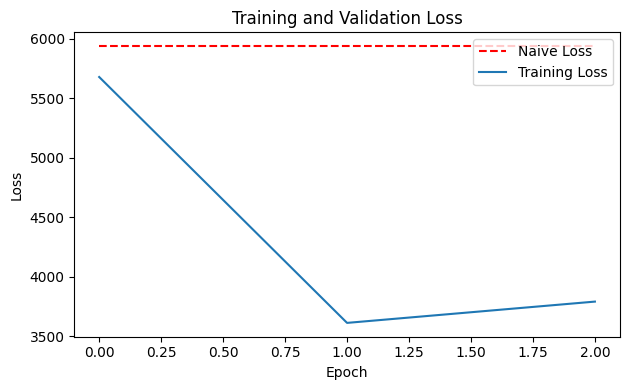

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 5773.7676 - mae: 40.1775 - mse: 2419.3335


epoch/epoch,▁▅█
epoch/learning_rate,▁▁▁
epoch/loss,█▁▂
epoch/mae,█▁▁
epoch/mse,█▁▁
epoch/val_loss,▃▁█
epoch/val_mae,▁▂█
epoch/val_mse,▁▁█
epoch/epoch,2
epoch/learning_rate,0.071
epoch/loss,3792.10181


In [241]:
history = model.fit(train_dataset_norm, epochs=3, local=True)
wandb.finish() 

In [8]:
secret_value

'6a41c5a7d5d063e33b4bea24275d0b3d7afd3865'

In [7]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: t-skorkowski. Use `wandb login --relogin` to force relogin


True

#### Sweep

In [ ]:

# Define the initializers you want to test
initializers = [
    tf.keras.initializers.RandomNormal(seed=42),
    tf.keras.initializers.RandomUniform(seed=42),
    tf.keras.initializers.HeNormal(seed=42),
    tf.keras.initializers.GlorotUniform(seed=42)
]

sweep_configuration = {
    "name": "bm_sweep",
    "method": "bayes",
    "metric": {"goal": "minimize", "name": "validation_loss"},
    "count": 200,
    "parameters": {
        "lstm_layers_units": {"values": [(0,0), (3,5), (10,25)]},
        "dense_layers_per_step": {"values": [10, 17, 27]},
        "dropout_rate": {"values": [0.1, 0.2, 0.3]},
        "kernel_initializer": {"values": [0,1,2,3]},
        "num_bins_num_bands": {"values": [(12, 3), (12,9), (32,9), (60,3), (60,9)]},
        "lr": {"distribution": "uniform",
               "min": 0.0001,
               "max": 0.1},
        "batch_size": {"values": [16, 32, 64]},
        "epochs": {"values": [20]},
        "optimizer": {"values": ["adam", "rms", "nadam"]},
    },
}

sweep_id = wandb.sweep(sweep_configuration,
                      project="blue-marble")
wandb.agent(sweep_id, function=train_wandb)



In [7]:
wandb.finish()

epoch/epoch,▁▅█
epoch/learning_rate,▁▁▁
epoch/loss,█▅▁
epoch/mae,█▇▁
epoch/mse,█▇▁
epoch/val_loss,▂█▁
epoch/val_mae,▁█▃
epoch/val_mse,▁█▄
epoch/epoch,2
epoch/learning_rate,0.04038
epoch/loss,16149.87109


In [230]:
model.evaluate(test_dataset)

 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 1148.8911 - mae: 27.2149 - mse: 1148.6067

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 2481.3469 - mae: 31.6095 - mse: 1512.1100


[3108.719482421875, 33.33673858642578, 1707.779541015625]

In [22]:
print(model.job_name)

tf.Tensor(4171.9155, shape=(), dtype=float32)
lively-foie-gras


In [ ]:
for layer in model.layers:
    # Get weights for the layer
    weights = layer.get_weights()
    
    # Check if the layer has weights
    if weights:
        print(f"Layer: {layer.name}")
        for i, weight in enumerate(weights):
            print(f"  Weight {i+1} shape: {weight.shape}")
            print(f"  Weight {i+1} values: \n{weight}\n")
    else:
        print(f"Layer: {layer.name} has no weights.")

#### Check predictions

In [242]:
predictions = model.predict(test_dataset_norm)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


In [ ]:
for data in train_dataset_norm.take(2):
    print(data[1].numpy())

predictions

In [243]:
np.unique(predictions)

array([124.29359], dtype=float32)

In [235]:
actual_labels

array([[264.1],
       [210. ],
       [147.1],
       ...,
       [205.9],
       [199.5],
       [186. ]], dtype=float32)

ValueError: x and y must be the same size

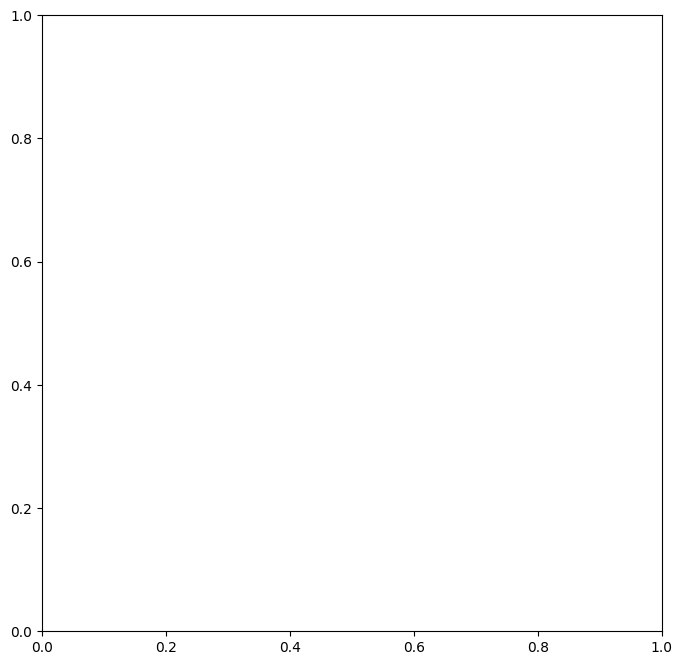

In [233]:
actual_labels = np.concatenate([response.numpy() for _, response in train_dataset_norm], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, predictions, alpha=0.5, edgecolors='k')
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.show()

In [ ]:
for layer in model.layers:
    print(layer.weights)

In [57]:
features = []
labels = []
for sample in test_dataset:
    features.append(sample[0].numpy().flatten())
    labels.append(sample[1].numpy())


In [61]:
print(f"test sample1:\n {features[0]}\n")
print(f"test sample2:\n {features[1]}\n")


test sample1:
 [-0.6592317  -0.2092626  -0.6655801  -0.7623781  -0.6529931  -0.27874988
  0.35314536 -0.51382405 -0.40834898 -0.35835764 -0.24685165 -0.6743143
 -1.0195754  -0.705815   -0.15236697  0.8574425   8.123357   -0.22869474
 -0.6688014  -0.31867352 -0.4851288  -0.30246803 -0.22383074 -0.16903086
  0.          0.          0.         -0.6592317  -0.21149738 -0.6761066
 -0.83425516 -0.84774035  0.30552936 -0.49671593 -0.48225805 -0.40834898
 -0.35835764 -0.24902922 -0.6772331  -1.0333351  -0.87355006 -0.1419926
  2.0916939   1.0249252   0.18295565 -0.63991153 -0.3297159  -0.5156928
 -0.30246803 -0.22383074 -0.16903086  0.          0.          0.
  0.03877835 -0.15115824  0.38180387 -0.08689696 -0.8838047  -0.7494193
 -0.5545296  -0.36651614  0.15705729  0.7474315  -0.12273022  0.5574018
 -0.26186943 -0.7202129  -0.79840666 -0.7144814  -0.47713205  0.04573886
 -0.33303648 -0.54346484 -0.420405   -0.10019842  1.3877505   5.9160795
  0.          0.          0.        ]

test sample2

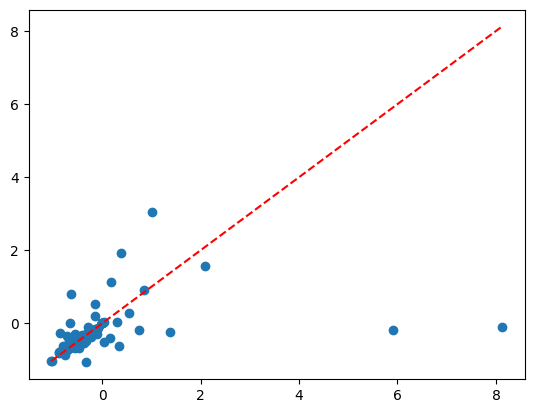

In [60]:
plt.scatter(features[0], features[1])
plt.plot([min(features[0]), max(features[0])], [min(features[0]), max(features[0])], 'r--')
plt.show()


In [208]:
model.summary()

Model: "time_dependent_dense_lstm_model_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_80 (LSTM)                  │ (10, 120)              │       230,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_778 (Dense)               │ (10, 1)                │           121 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_737            │ (10, 3, 360)           │       259,560 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_738            │ (10, 3, 360)           │       129,960 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_739            │ (10, 3, 360)           │       129,960 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_740            │ (10, 3, 360)           │       129,960 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_741            │ (10, 3, 360)           │       129,960 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_742            │ (10, 3, 360)           │       129,960 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_743            │ (10, 3, 360)           │       129,960 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_744            │ (10, 3, 360)           │       129,960 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_745            │ (10, 3, 360)           │       129,960 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_746            │ (10, 3, 360)           │       129,960 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_747            │ (10, 3, 360)           │       129,960 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_748            │ (10, 3, 360)           │       129,960 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_749            │ (10, 3, 360)           │       129,960 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_750            │ (10, 3, 360)           │       129,960 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_751            │ (10, 3, 360)           │       129,960 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 10,828,806 (41.31 MB)

 Trainable params: 3,609,601 (13.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,219,205 (27.54 MB)